# 🎾 Tennis Autodistillation: Dataset Generation and Model Training

### 🛠️ Project Goal  

The goal of this project is to create a dataset in a fully automated way, which will be used to train computer vision models. These models will form part of a pipeline designed to process videos of tennis matches.


### 🔍 Pipeline Overview  
The pipeline used to analyze video frames consists of the following five components:

1. **Frame Classification**  
2. **Player Detector**  
3. **Court Landmarks Detector**  
4. **Homography Matrix Computation**  
5. **Obtain Players' (x, y) Position on the Minimap**

In the image below, you can see the full pipeline scheme.

![Pipeline Overview](assets/pipeline_overview.png)

This notebook will cover the following parts:
* Download the dataset  
* Extract frames from the videos  
* Frame Classification  
    * Dataset creation  
    * Model training  
* Player Detector  
    * Dataset creation  
    * Model training  
* Court Landmarks Detector  
    * Dataset creation  
    * Model training  
* Homography Matrix Computation  
* Obtain Players' (x, y) Position on the Minimap  

🚀 **Let's get started and enjoy the process!** 



---------------------------------------------------------------------

### 📥 Download the dataset


Let's start by running the `download_dataset.sh` script to download the videos. This script will download the videos from the provided list of links and save them in the `dataset/videos` folder.

In [1]:
# - Run the script
!bash download_dataset.sh

Now, let's define the path to the dataset.

In [41]:
from pathlib import Path
dir_dataset = Path("dataset")
dir_dataset_videos = dir_dataset / "videos"

lst_video_paths = list(dir_dataset_videos.glob("**/*.mp4"))
print(f"Dataset contains {len(lst_video_paths)} videos:")
for video_path in lst_video_paths:
    print(str(video_path))

Dataset contains 8 videos:
dataset/videos/red_clay-video_1.mp4
dataset/videos/grass-video_1.mp4
dataset/videos/hard_laykold-video_2.mp4
dataset/videos/hard_plexicushion-video_2.mp4
dataset/videos/hard_laykold-video_1.mp4
dataset/videos/hard_plexicushion-video_1.mp4
dataset/videos/red_clay-video_2.mp4
dataset/videos/grass-video_2.mp4


-------

## 🎥 Extract frames from the videos  


Let's extract the frames from the videos. This will create a new folder called `dataset/frames` with the frames extracted from the videos.

In [42]:
from tennis_autodistill.utils.video import split_video_to_frames

# Define the path to the extracted frames
dir_dataset_frames = dir_dataset / "frames"

In [ ]:
# - Split the videos into frames
for video_path in lst_video_paths:
    split_video_to_frames(
        video_path=video_path,
        output_folder = dir_dataset_frames,
        frames_per_second=1,
        overwrite=False
)

In [43]:
lst_extracted_frames = list(dir_dataset_frames.glob("**/*.jpg"))
total_extracted_frames = len(lst_extracted_frames)
print(f"Total extracted frames: {total_extracted_frames}")


Total extracted frames: 4712


Let's visualize some of the extracted frames:

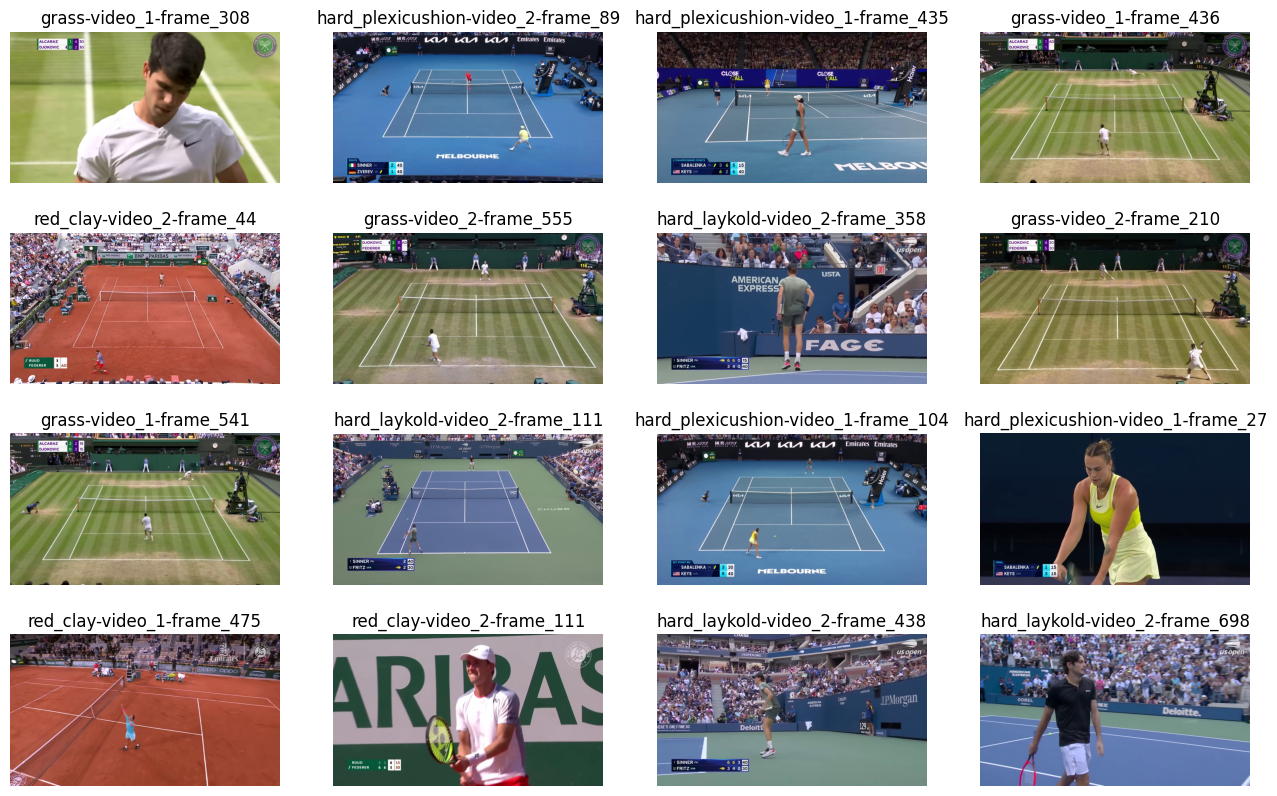

In [44]:
import cv2
import supervision as sv
import random
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 10)

selected_frames = random.sample(lst_extracted_frames, SAMPLE_SIZE)
titles = [
    image_path.stem
    for image_path
    in selected_frames]
images = [
    cv2.imread(str(image_path))
    for image_path
    in selected_frames[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)


❗**Notice** that not all frames contain a full tennis court showing a clear view of the players and the court. Some frames are just commercials, close-ups or even details of the court, that usually in a tennis match, it represents a replay.

The next step is to "automagically" 🧙 annotate frames that display a full tennis court with a clear view of both the players and the court. This will allow us to train a model capable of distinguishing between different scenarios, such as commercials, close-ups, partial court views, and actual gameplay.

## 1. Frame Classification  

In this part, we will use chatGPT to annotate the frames we extracted. This will allow us to train a model capable of distinguishing between different scenarios.

We will start by separating the frames by court types and split them into training and testing sets.

### 1.1. Dataset creation (frame classification)

First, let's separate the frames by court types. Note that the name of each frame or video starts with a court type.

In [45]:
dict_videos_court_type = {}
for video_path in lst_video_paths:
    court_type = video_path.stem.split("-")[0]
    dict_videos_court_type.setdefault(court_type, []).append(video_path.resolve())

dict_videos_court_type


{'red_clay': [PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/red_clay-video_1.mp4'),
  PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/red_clay-video_2.mp4')],
 'grass': [PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/grass-video_1.mp4'),
  PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/grass-video_2.mp4')],
 'hard_laykold': [PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/hard_laykold-video_2.mp4'),
  PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/hard_laykold-video_1.mp4')],
 'hard_plexicushion': [PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/hard_plexicushion-video_2.mp4'),
  PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/hard_plexicushion-video_1.mp4')]}

We first define the proportions of videos to be used for training and testing sets, considering the different types of courts. 

We want, for instance, 50% of the videos with "grass" court type will be used for training and 50% for validation. Similary, 50% of the videos with "red clay" court type will be used for training and 50% for validation.

As each video has a different number of frames, the amount of frames to be used for training and testing will be different.

In [46]:
import random
random.seed(2026)

# Proportions of training and validation sets
prop_train = 0.5 #  50% into training set
prop_val = 0.5 #  50% into validation set

videos_split = {"train": [], "val": []}
# For each court type, separate videos into training and testing sets
for court_type, videos in dict_videos_court_type.items():
    # Shuffle videos
    random.shuffle(videos)
    # Get the number of videos to use for training and validation
    num_train = int(len(videos) * prop_train)
    # Separate videos into training and validation sets
    videos_split["train"].extend(videos[:num_train])
    videos_split["val"].extend(videos[num_train:])

videos_split

{'train': [PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/red_clay-video_2.mp4'),
  PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/grass-video_1.mp4'),
  PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/hard_laykold-video_1.mp4'),
  PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/hard_plexicushion-video_1.mp4')],
 'val': [PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/red_clay-video_1.mp4'),
  PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/grass-video_2.mp4'),
  PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/hard_laykold-video_2.mp4'),
  PosixPath('/home/rafael_shotquality_com/code/tennis-autodistill/dataset/videos/hard_plexicushion-video_2.mp4')]}

Let's now separate the frames in each split.

In [47]:
dict_frames_split = {}

# Get a list of frames in each split
for split_name, lst_videos in videos_split.items():
    # Create the split folder
    dir_split = dir_dataset_frames / split_name
    dir_split.mkdir(parents=True, exist_ok=True)

    for video_path in lst_videos:
        video_name = video_path.stem
        lst_frames_split = list(dir_dataset_frames.glob(f"{video_name}*.jpg"))

        # Move the files to the split folder
        for frame_path in lst_frames_split:
            frame_path.rename(dir_split / frame_path.name)

        dict_frames_split.setdefault(split_name, []).extend(lst_frames_split)
    print(f"Number of frames in {split_name}: {len(dict_frames_split[split_name])}")


Number of frames in train: 2284
Number of frames in val: 2428


In this part, we will use chatGPT to annotate the frames we extracted. We want chatGPT to annotate the frames with the following ontology:

In [48]:
dict_ontology = {
            "an image showing the full playable area of a tennis court with camera positioned higher and centered, providing a full view of the entire court": "game_play",
            "an image showing partially the playable area of a tennis court, providing a partial view of the court": "partial_view",
            "a close-up shot of a tennis player": "close_up",
            "anything else": "ignore1",
            "none": "ignore2"
        }

which will make our classification model to classify each frame in one of the following classes:

In [49]:
classes_to_return = [f"* {v}" for v in dict_ontology]
classes_to_return

['* an image showing the full playable area of a tennis court with camera positioned higher and centered, providing a full view of the entire court',
 '* an image showing partially the playable area of a tennis court, providing a partial view of the court',
 '* a close-up shot of a tennis player',
 '* anything else',
 '* none']

For that, we will pass the following prompt to chatGPT:

In [50]:
prompt = f"""What is in the best description of the image?
Return one of these options that best describes the image:
{'\n'.join(classes_to_return)}
You MUST return only one of the options from that list. Nothing besides that.
"""
print(prompt)

What is in the best description of the image?
Return one of these options that best describes the image:
* an image showing the full playable area of a tennis court with camera positioned higher and centered, providing a full view of the entire court
* an image showing partially the playable area of a tennis court, providing a partial view of the court
* a close-up shot of a tennis player
* anything else
* none
You MUST return only one of the options from that list. Nothing besides that.



Now, let's use the `GPT4V` class to annotate the frames.

Don't forget to set your OpenAI API key in the .env file.  

For example:
```
OPENAI_API_KEY=sk-...
```

In [51]:
from dotenv import load_dotenv
import os

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
load_dotenv()

True

In [52]:
from autodistill.detection import CaptionOntology
from autodistill_gpt_4v import GPT4V

gpt4v = GPT4V(
    ontology=CaptionOntology(
        dict_ontology
    ),
    api_key=OPENAI_API_KEY,
    resize_min=360,
    prompt=prompt
)

Let's now make calls to ChatGPT API so it can annotate our frames:

In [53]:
# A shelve file is used to store the results of the annotations
shelve_file = dir_dataset / "frames_prediction_v0.db"
# Define the output folder for the annotations
dir_output_annotations_gpt4v = dir_dataset / f"frames_labeled_by_gpt4v"


In [15]:
# - Labeling images with ChatGPT
def post_process(result):
    result = result.lower()
    result = result.replace("*", "")
    result = result.replace("'", "")
    result = result.strip()
    return result

# For each split, call ChatGPT to annotate the frames
for split_name in ["train", "val"]:
    dir_split = dir_dataset_frames / split_name
    dir_output_annotations = dir_output_annotations_gpt4v / split_name
    # Use autodistill to label the frames
    dataset = gpt4v.label(dir_split.resolve(), extension=".jpg",
                output_folder=dir_output_annotations.resolve(),
                fn_post_process=post_process,
                shelve_file=Path(shelve_file).resolve())


All images 2284 already labeled
Labeled dataset created!
All images 2428 already labeled
Labeled dataset created!


Let's visualize some of the results:

In [54]:
import cv2
import supervision as sv

lst_output_annotations_gpt4v = list(dir_output_annotations_gpt4v.glob("**/*.jpg"))

# Randomly sample SAMPLE_SIZE images
lst_selected_samples = random.sample(lst_output_annotations_gpt4v, SAMPLE_SIZE)
# Get the titles based on their folder name
titles = [image_path.parts[-2] for image_path in lst_selected_samples]

images = [
    cv2.imread(str(image_path))
    for image_path
    in lst_selected_samples]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)


Not bad, huh? 🤩

Now, let's train a model with those samples, so that the model can learn how to classify the frames.

### 1.2. Model training (frame classification)


We will use the images annotated by ChatGPT with autodistill to train a YOLOv11 nano model, which is a very small model that can be used for real-time applications.

In [1]:
# - Import the YOLOv11 classification model and train it
from autodistill_yolov11 import YOLOv11

yolo_classification_model = YOLOv11("yolo11n-cls.pt")
# We disable erasing, mosaic, and crop, because the samples of game_play and partial_view would be very similar
yolo_classification_model.train(dir_output_annotations_gpt4v, epochs=200, device=0, erasing=0, mosaic=0, crop_fraction=1.)

If we use the annotations from ChatGPT, we can measure the accuracy of our trained model to see how close to ChatGPT's annotations it is.

We will save the images classified by YOLO for further visualization.

In [55]:
import shutil
from ultralytics import YOLO
from itertools import chain
from tqdm import tqdm

In [57]:
# - Load the classification model
yolo_classification_model = YOLO("runs/classify/train/weights/best.pt")
# Define a folder where images will be saved
dir_classified_frames = dir_dataset / "frames_classified_by_yolo"


In [33]:

EPSILON = 1e-9

results = {}
for split in ["train", "val"]:
    results.setdefault(split, {})
    print(f"\n🔍 Results for {split}:")
    dir_split = dir_output_annotations_gpt4v / split
    for target_class_dir in dir_split.glob("*"):
        target_class_name = target_class_dir.stem
        results[split].setdefault(target_class_name, [])

        # Get all samples in the target class
        lst_samples = list(target_class_dir.glob("*.jpg"))

        # Run the model on all samples
        pbar = tqdm(lst_samples, total=len(lst_samples))
        for img_path in pbar:
            pbar.set_description(f"🔥 Running model on {img_path.stem}")
            pred = yolo_classification_model.predict(img_path, verbose=False)
            class_name = yolo_classification_model.names[pred[0].probs.top1]
            results[split][target_class_name].append(class_name == target_class_name)

            # Copy the images to its folder following its prediction
            dir_output_class = dir_classified_frames / target_class_name
            dir_output_class.mkdir(parents=True, exist_ok=True)
            shutil.copy(img_path, dir_output_class / img_path.name)

        total_correct = sum(results[split][target_class_name])
        total_samples = len(results[split][target_class_name])
        if total_samples == 0:
            print(f"⚠️ No samples for {split} '{target_class_name}'")
            continue
        split_class_accuracy = total_correct / (total_samples + EPSILON)
        print(f"📊 Accuracy for '{target_class_name}': {100 * split_class_accuracy:.2f}%")

    # Accuracy for the entire split
    flat_results = list(chain.from_iterable(results[split].values()))
    total_correct = sum(flat_results)
    total_samples = len(flat_results)
    total_accuracy = total_correct / (total_samples + EPSILON)
    print(f"✅ Final accuracy for split '{split}': {100 * total_accuracy:.2f}%")




🔍 Results for train:


🔥 Running model on grass-video_1-frame_29: 100%|██████████| 944/944 [00:52<00:00, 18.00it/s]             


📊 Accuracy for 'close_up': 96.61%


🔥 Running model on grass-video_1-frame_5: 100%|██████████| 4/4 [00:00<00:00, 25.18it/s]              


📊 Accuracy for 'ignore2': 50.00%


🔥 Running model on hard_plexicushion-video_1-frame_135: 100%|██████████| 276/276 [00:11<00:00, 24.51it/s]


📊 Accuracy for 'partial_view': 88.77%


🔥 Running model on hard_plexicushion-video_2-frame_468: 100%|██████████| 233/233 [00:10<00:00, 21.28it/s]


📊 Accuracy for 'ignore1': 88.84%


🔥 Running model on hard_laykold-video_1-frame_404: 100%|██████████| 2585/2585 [02:10<00:00, 19.88it/s]     


📊 Accuracy for 'game_play': 99.07%
✅ Final accuracy for split 'train': 97.15%

🔍 Results for val:


🔥 Running model on hard_laykold-video_1-frame_416: 100%|██████████| 850/850 [00:35<00:00, 23.62it/s]     


📊 Accuracy for 'close_up': 95.88%


🔥 Running model on hard_plexicushion-video_2-frame_360: 100%|██████████| 3/3 [00:00<00:00, 15.91it/s]


📊 Accuracy for 'ignore2': 33.33%


🔥 Running model on hard_plexicushion-video_1-frame_135: 100%|██████████| 268/268 [00:13<00:00, 19.30it/s]


📊 Accuracy for 'partial_view': 88.06%


🔥 Running model on hard_plexicushion-video_2-frame_468: 100%|██████████| 272/272 [00:09<00:00, 27.37it/s]


📊 Accuracy for 'ignore1': 91.91%


🔥 Running model on hard_laykold-video_1-frame_404: 100%|██████████| 2485/2485 [01:37<00:00, 25.39it/s]     

📊 Accuracy for 'game_play': 99.11%
✅ Final accuracy for split 'val': 97.09%


It is good to see some of the images that were classified as "game_play" by yolo:

In [59]:
lst_classified_frames = list(dir_classified_frames.glob("**/*.jpg"))

# Randomly sample SAMPLE_SIZE images
lst_selected_samples = random.sample(lst_classified_frames, SAMPLE_SIZE)
# Get the titles based on their folder name
titles = [image_path.parts[-2] for image_path in lst_selected_samples]

images = [
    cv2.imread(str(image_path))
    for image_path
    in lst_selected_samples
]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)


## Using Grounded SAM to annotate the frames 

In order to train the player detector, we will use Grounded (SAM) to retrieve the players' mask, which will be converted to a bounding box.

SAM will also be used to retrieve the court mask, which will be used to  find the corners of the court, and then compute the homography matrix.

In [60]:
from autodistill_grounded_sam import GroundedSAM
from autodistill.detection import CaptionOntology

# Let's define a directory where the SAM annotations will be saved
dir_output_annotations_sam = dir_dataset / "sam_labeled_data"

sam_ontology=CaptionOntology(
        {"playable area of a tennis court": "playable_area",
         "tennis player": "tennis_player"}
    )
id2class = {i:class_info[1] for i, class_info in enumerate(sam_ontology.promptMap)}

We will use SAM to annotate the frames classified as "game_play" by YOLO.

In [4]:
# - Create the Grounded SAM model:
base_model_grounded_sam = GroundedSAM(ontology=sam_ontology)
# Run the SAM model to annotate the frames
labeled_mask_dataset = base_model_grounded_sam.label(str(dir_classified_frames / "game_play"),
                                                      extension=".jpg",
                                                      output_folder=str(dir_output_annotations_sam),
                                                      record_confidence=True)


In [25]:
# - Load pre-computed SAM annotations
import pickle
labeled_mask_dataset = pickle.load(open("labeled_mask_dataset.pkl", "rb"))

In [61]:
len(labeled_mask_dataset)

3075

### Clean annotations

We will use the masks predicted by SAM to create a dataset for the player detector and the keypoints detector.

For the player detector, we will transform the masks to bounding boxes.

🍒 For the keypoints detector, we will transform the masks to keypoints to get the 4 corners of the playable area, and we will use the homography matrix to infer the position of the other 14 points of the court map. 

In [26]:
# Using supervision to visualize the labeled dataset annotated with SAM
import supervision as sv
mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

Now, we will loop over the annotations performed by SAM. The goal is to remove bad annotations and prepare the dataset for player detector and landmark 

In [27]:
from tennis_autodistill.utils.coords_court_map import COORDS_COURT_MAP

# Create a dictionary to map the points to their ids
points_ids2classes = {point_name:idx for idx, point_name in enumerate(COORDS_COURT_MAP)}

THRESH_PLAYABLE_AREA = 0.97
images = []
image_names = []
dict_imgs2kpts = {}
# Dictionary to store the detections of the playable area for each image
dict_xyxy_playable_area = {}
# Dictionary to store the detections of the players for each image
dict_imgs2players = {}


In [28]:
import numpy as np

# Function to get the upper left corner of a mask
def get_upper_left_corner(mask, img_w, thresh_width=0.15):
    # Get the rows that have more than 15% of the image width
    rows_sum = np.sum(mask, axis=1)
    valid_rows = np.where(rows_sum > thresh_width*img_w)[0]
    first_row, last_row = valid_rows[0].item(), valid_rows[-1].item()
    # On the first row, get the first and last columns that has a 1
    first_row_first_col = np.where(mask[first_row] == 1)[0][0].item()
    return (first_row_first_col, first_row)

In [29]:
from pathlib import Path
import cv2
from tennis_autodistill.utils.transformations import transform_image, transform_point

In [31]:
# - Load the tennis court map
tennis_court_map = cv2.imread("tennis_court_full_map.png")

# Loop over the SAM annotations
for i, (image_path, image, annotation) in enumerate(labeled_mask_dataset):
    if not Path(image_path).exists():
        print(f"⚠️ Image {image_path} does not exist")
        continue

    # Get image dimensions
    img_h, img_w = image.shape[:2]

    # Get all predicted classes
    predicted_classes = [id2class[idx] for idx in annotation.class_id]

    # Filter 1: Ignore images that do not have 2 players and 1 playable area
    if predicted_classes.count("tennis_player") != 2 or predicted_classes.count("playable_area") != 1:
        continue

    # Filter 2: Ignore images that the playable area is touching the borders of the image
    id_det_playable_area = predicted_classes.index("playable_area")
    xyxy_playable_area = annotation.xyxy[id_det_playable_area]
    # Most left and most right points of the playable area
    x_min, y_min, x_max, y_max = xyxy_playable_area
    p_bottom_left = x_min, y_max
    p_bottom_right = x_max, y_max
    width_bbx = xyxy_playable_area[2] - xyxy_playable_area[0]
    high_bbx = xyxy_playable_area[3] - xyxy_playable_area[1]
    # Check if the playable area is touching the borders of the image (97% of the image)
    if high_bbx/img_h > THRESH_PLAYABLE_AREA or width_bbx/img_w > THRESH_PLAYABLE_AREA:
        continue

    # Sometimes the mask is not a single connected component, so we need to get the largest connected component
    # Get the mask of the playable area
    mask_playable_area = annotation.mask[id_det_playable_area]
    # Get the largest connected component of the playable area
    mask_uint8 = annotation.mask[id_det_playable_area].astype(np.uint8) * 255
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)
    # Identify the largest component (excluding background)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    # Create a mask for the largest component
    largest_mask = 1*(labels == largest_label)

    # Get the corners of the largest_mask (playable area)
    p1 = get_upper_left_corner(largest_mask, img_w)
    # flip horizontally to get the upper right corner
    p2 = get_upper_left_corner(np.fliplr(largest_mask), img_w)
    p2 = (img_w - p2[0], p2[1])
    # flip vertically to get the lower left corner
    p3 = get_upper_left_corner(np.flipud(largest_mask), img_w,0.30)
    p3 = (p3[0], img_h - p3[1])
    # flip horizontally and vertically to get the lower right corner
    p4 = get_upper_left_corner(np.flipud(np.fliplr(largest_mask)), img_w, 0.30)
    p4 = (img_w - p4[0], img_h - p4[1])

    # Filter 3: Ignore images that the edges of the playable area are not aligned with the corners of the bounding box of the playable area
    # Distance from the bottom left and bottom right corners of the playable area with the bounding box of the playable area
    d1 = np.linalg.norm(np.array(p3) - np.array(p_bottom_left))
    d2 = np.linalg.norm(np.array(p4) - np.array(p_bottom_right))
    if d1 > 15 or d2 > 15:
        continue

    # Filter 4: Ignore images that the playable are has considerable holes
    # Get the bbx of the playable area
    true_coords = np.argwhere(mask_playable_area)
    min_y, min_x = true_coords.min(axis=0)  # Top-left corner (y, x)
    max_y, max_x = true_coords.max(axis=0)  # Bottom-right corner (y, x)
    # Merge the playable area mask with the players to remove the players
    masks_players = [annotation.mask[i] for i, class_name in enumerate(predicted_classes) if class_name == "tennis_player"]
    # Dilate the masks of the players
    masks_players = [cv2.dilate(mask_player.astype(np.uint8), np.ones((15, 15))) for mask_player in masks_players]
    mask_playable_area_players = mask_playable_area.copy()
    for mask_player in masks_players:
        mask_playable_area_players = np.logical_or(mask_playable_area_players, mask_player)
    # Crop the merged playable area mask with players mask to the bbx of the playable area
    mask_playable_area_players = mask_playable_area_players[min_y:max_y, min_x:max_x]
    area_mask_playable_area_players = np.sum(mask_playable_area_players)
    # Compute the theoretical area of the trapezoid (playable area)
    trapezoid_area = ((p4[0]-p3[0]) + (p2[0]-p1[0])) * (mask_playable_area_players.shape[0]) / 2
    # Check possible holes in the mask_playable_area_players
    if area_mask_playable_area_players/trapezoid_area < THRESH_PLAYABLE_AREA:
        continue

    # Save the detections of the players in the dictionary
    bbx_players = [annotation.xyxy[i] for i, class_name in enumerate(predicted_classes) if class_name == "tennis_player"]
    # Make a dictionary with the player detections (player class id = 0)
    dict_imgs2players[image_path] = sv.Detections(xyxy=np.array(bbx_players), class_id=np.zeros(len(bbx_players)))

    # Let's compute homography matrix that maps p1, p2, p3, p4 to COORDS_COURT_MAP
    src_pts = np.array([COORDS_COURT_MAP["p1"], COORDS_COURT_MAP["p2"], COORDS_COURT_MAP["p3"], COORDS_COURT_MAP["p4"]])
    dst_pts = np.array([p1, p2, p3, p4])
    H, _ = cv2.findHomography(src_pts, dst_pts)
    # Project the image to the court map
    transformed_image = transform_image(tennis_court_map, H, (img_w, img_h))
    # Use H to transform all 14 points of the court map to the image
    img_with_point = image.copy() # For drawing only
    lst_keypoints, lst_class_ids = [], []
    for point_name, point in COORDS_COURT_MAP.items():
        transformed_point = transform_point(H, point)
        transformed_point = tuple(map(int, transformed_point))
        lst_keypoints.append(transformed_point)
        lst_class_ids.append(points_ids2classes[point_name])

    # Transform the list of keypoints to a (n,1,2) array
    n = len(lst_keypoints)  # Number of detected objects
    xy = np.array(lst_keypoints).reshape(n, 1, 2)
    confidences = np.ones((n, 1))
    class_ids = np.array(lst_class_ids)

    # Store the keypoints
    dict_imgs2kpts[image_path] = sv.KeyPoints(xy, class_ids, confidences)
    # Store the detections of the playable area
    dict_xyxy_playable_area[image_path] = tuple(map(float, xyxy_playable_area))


Let's check the number of images in each dictionary required to train the models:

In [62]:
len(dict_imgs2kpts), len(dict_xyxy_playable_area), len(dict_imgs2players)

(600, 600, 600)

## Player Detector

### 2.1. Dataset creation (player detector)

   Let's create a dataset for the detections of the players obtained with SAM:

In [63]:
dir_output_players = dir_dataset / "players"

In [64]:
# Prepare the dataset for the player detector
dataset_players = sv.DetectionDataset(["player"],
                                      images=list(dict_imgs2players.keys()),
                                      annotations=dict_imgs2players)

Split the dataset into training and validation:

In [65]:
from supervision.dataset.formats.yolo import save_yaml_file

In [66]:
# Split dataset into training and validation and save them  (folder dataset/player will be created)
ds_train, ds_val = dataset_players.split(split_ratio=0.8)
dir_images_train = dir_output_players / "train" / "images"
dir_labels_train = dir_output_players / "train" / "labels"
ds_train.as_yolo(images_directory_path = dir_images_train, annotations_directory_path = dir_labels_train)
dir_images_val = dir_output_players / "val" / "images"
dir_labels_val = dir_output_players / "val" / "labels"
ds_val.as_yolo(images_directory_path = dir_images_val, annotations_directory_path = dir_labels_val)
data_yaml_path = dir_output_players / "data.yaml"
# Save the data.yaml file
data = {"path": str(dir_output_players.resolve()),
        "train": "train",
        "val": "val",
        "names": dataset_players.classes}
save_yaml_file(data=data, file_path=data_yaml_path)


### 2.2. Model training (player detector)


In [43]:
from autodistill_yolov11 import YOLOv11

In [ ]:
# - Train the player detector
yolo_player_model = YOLOv11("yolo11n.pt")
yolo_player_model.train(data_yaml_path, epochs=200, device=0)


We can visualize the player detections looking at the results in the `runs/detect/train` folder.

## 3. Court Key Points Detector

### 3.1. Dataset creation (keypoints detector)


In [67]:
from tennis_autodistill.utils.yolo import dataset_keypoints_to_yolo

dir_output_keypoints = dir_dataset / "court_keypoints"

In [68]:
# Creating the dataset for the keypoints (folder dataset/court_keypoints will be created)
dataset_keypoints = sv.DetectionDataset(list(dict_imgs2kpts.keys()),
                                        list(dict_imgs2kpts.keys()),
                                        dict_imgs2kpts)
dataset_keypoints_to_yolo(
    dataset_keypoints=dataset_keypoints,
    dict_keypoints_classes=points_ids2classes,
    dataset_bbxes=dict_xyxy_playable_area,
    dir_output=dir_output_keypoints,
)


YOLO configuration file created at: /home/rafael_shotquality_com/code/tennis-autodistill/dataset/court_keypoints/data.yaml


### 3.2. Model training (keypoints detector)


In [ ]:
# - Train the keypoints detector
yolo_keypoint_model = YOLOv11("yolo11n-pose.pt")
yolo_keypoint_model.train(dir_output_keypoints / "data.yaml", epochs=200, device=0)

We can visualize the keypoints detected by the model looking at the results in the `runs/pose/train` folder.

-------------

🎉 We have successfully trained our `frame classifier`, `player detector` and `keypoints detector`! 🎉

You can use the output `.pt` generated with this notebook with the `scripts/run_pipeline.py` and run inferences in your videos.

-------------